This notebook represents my attempt to solve the problem of direct estimation of fetal body part measurements in ultrasound. In clinical practice these measurements are taken by a medical doctor or specialized technician, who follow strict guidelines and place measuring callipers to get desired measurements.

When it comes to automation of this process, traditionally such estimates are achived by using U-Net type of neural networks, which are built with concept of image segmentation in mind. Segmentation masks are subsequently measured with the use of algorithms that find the shape and provide pixel-valued measurements which have to be properly scaled in order to be transformed to the metric system.

While direct estimation (i.e without segmentation) has been attempted before, it has never been done with the use of a varied dataset that contains more than one type of fetal body part. I was inspired to try and train my model after reading these papers: https://openreview.net/pdf?id=RwYqA6AjS and https://www.mdpi.com/2313-433X/8/2/23

I used a proprietary dataset ultrasound dataset, containing a total of 2013 images of fetal heads, abdomens and femurs. 

In [12]:
import os
import glob
import numpy as np
import time
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
from dataloader_only_regression import FetalDatasetResampled
from transforms import transform_basic, train_transform_fetai
import torchvision.transforms as transforms
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

Fetal ultrasound images can greatly differ in apperance, depending on the ultrasound machine model, as well as preferences of the person who performs the examination. One of the most important factors which make it difficult for a regression model to achieve good results is the fact that some of the images are zoomed-in, while others are not. Therefore, the most important first step is to fix that by resampling the images. Ultrasound data is saved in DICOM file format, and in those files' metadata, there is an attribute named pixel spacing, which encodes the physical distance between pixels. Thanks to that it is possible to resample the dataset in such way that the structures of the same size appear so, despite different zoom intensity present during the recording. 

The cell below contains code used to transform the dataset which was initiall in DICOM format to properly resampled png images which can be used to train the model. 

In [ ]:
files = sorted(glob.glob("./data_dcm/" + "**/*.**",
                                recursive=True))
images = [f for f in files if not "_mask" in f]
masks = [f for f in files if "_mask" in f]

transform = transforms.Compose([tio.Resample(0.2), tio.CropOrPad((896, 896, 1), mask_name='mask')])

subjects = []
for (image_path, label_path) in zip(images, images):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        mask=tio.LabelMap(label_path),
    )
    subjects.append(subject)

for subject in subjects:
    transformed = transform(subject)
    img = transformed['image']['data']
    mask = transformed['mask']['data']

    dest = './data_resampled/'
    img_name = transformed['image']['path'].split('/')[-1][:-4]
    mask_name = img_name + "_mask"

    subfolder = transformed['image']['path'].split('/')[-2]
    
    if not os.path.exists(os.path.join(dest, subfolder)):
        os.makedirs(os.path.join(dest, subfolder))

    num = img.permute(3, 2, 1, 0).squeeze(0).squeeze(0) 
    num = num.numpy()

    img_to_save = Image.fromarray(num).convert("L")
    mask_to_save = Image.fromarray(msk)
    img_to_save.save(os.path.join(os.path.join(dest, subfolder, img_name + ".png",)))

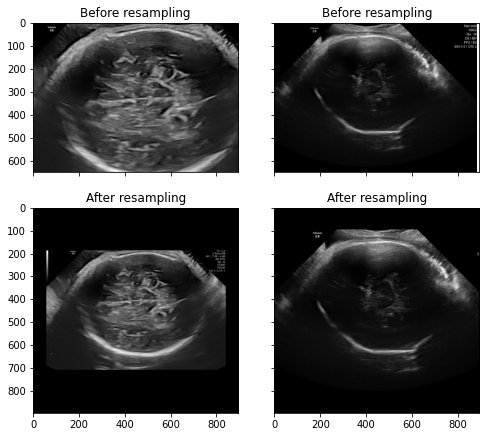

In [16]:
img1_path = './data_by_id/534/534_1_293.png' 
img2_path = './data_by_id/88/88_1_273.png'
img3_path = './data_resampled/534/534_1_293.png'
img4_path = './data_resampled/88/88_1_273.png'

img_1 = Image.open(img1_path)
img_2 = Image.open(img2_path)
img_3 = Image.open(img3_path)
img_4 = Image.open(img4_path)

imgs = [img_1, img_2, img_3, img_4]
titles = ["Before resampling", "Before resampling", "After resampling", "After resampling"]

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, im , title in zip(grid, imgs, titles):
    ax.set_title(title, fontdict=None, loc='center', color = "k")
    ax.imshow(im, cmap='gray')

plt.show()

The picture above shows a comparison between original (top row) and resampled images (bottom row). Note how the sizes of fetal skulls appear to be similal in the resampled images, which is in line with their actual measurements (33.6 cm vs 33.4 cm circumference).

Model used in this attempt is based on the well proven ResNet34, modified by adding a regression block as the last layer. This way, the model outputs two tensors, first used for classification of the fetal structure and the second to provide the estimated measurement value. The regressor layer has an additional dropout layer intended to prevent the network from overfitting.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x
    
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )

        self.avgpool = nn.AdaptiveMaxPool2d(2)
        
        # classification
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Linear(512, 3)
        ) 
        # regression
        self.fc2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Linear(2048, 512),
            nn.Linear(512, 128),
            nn.Linear(128, 1),
        ) 
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        return x1.float(),x2.float()

In order to help with convergence, labels encoding the original measurement values, as well as the tensor outputting the estimated measurements, were divided by 40 (value close to the maximum values of the original measurements), therefore restricting the values to 0-1 range which improves convergence. The cell above contains code used to create my dataloader. 

In [58]:
from torch.utils.data import Dataset


class FetalDatasetResampled(Dataset):
    def __init__(self,
                 data_path: str = None,
                 csv_path: str = None,
                 transform=None
                 ) -> None:

        self.data_path = data_path
        self.csv = self.preprocess_csv(csv_path)
        self.transform = transform

        files = sorted(glob.glob(self.data_path + "/**/*.png",
                                 recursive=True))
        
        self.images = [f for f in files if not "_mask" in f]
        self.masks = [f for f in files if "_mask" in f]
        
        self.labels = [int(f.split("/")[-1].split('_')[-2]) - 1 for f in self.images]

    def __getitem__(self,
                    index
                    ) -> type(tuple):

        img = Image.open(self.images[index]).convert("L")
        label = self.labels[index]

        filename = os.path.basename(self.images[index])[:-4]
        filename_short = filename.split("_")[:-1]
        filename_short = "_".join(filename_short)

        if self.transform is not None:
            img = self.transform(img)
        
        original_measurement = self.get_original_measurement(filename_short)
        return img, label, original_measurement

    def __len__(self):
        return len(self.images)

    def get_original_measurement(self, filename):
        original_measurement = float(self.csv.loc[filename]['original_measurement'])

        return original_measurement / 40

    def preprocess_csv(self, csv_path):
        csv = pd.read_csv(csv_path,
                          names=['filename', 'original_measurement', 'pixel_size'], header=None)
        csv['filename'] = csv['filename'].map(lambda x: "_".join(x.split("_")[:-1]))
        csv = csv.set_index('filename', inplace=False)
        return csv 

Model training has been divided into two stages. In both, the same dataset divided into training/validation (1800/213) subsets was used. First phase lasted for 200 epochs, and used a sum of L1 and CrossEntropy losses as the loss function. In the second phase, learning rate was threefold, and L1 loss component was replaced with mean squared error. I found that this way training went smoothly and the estimated measurements were getting close to desired values quickly, thanks to robust character of L1 loss and its resistance to outliers. 

However, using the L1 loss to minimize this error results in a more uneven spread of measurement error across the three fetal body parts. This is due to the fact that while head and abdomen measurement values are similar (mostly in range between 20 to 35 cm), femur ranges between 3 to 8 cm. 

For L1 loss the error value is linear, resulting proportionally higher differences between femur measurement estimations and ground truths. 

This is why I decided to perform additional training for 100 epochs, replacing L1 loss with MSE, which is less tolerant toward outliers.

The cell below contains code used to train the model.

In [ ]:
model = ResNet34()
model = model.cuda()

criterion1 = nn.CrossEntropyLoss()

# in phase 1
criterion2 = nn.L1Loss()
# in phase 2    
# criterion2 = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)

model_folder = os.path.abspath("./models")
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_path = os.path.join(model_folder, MODEL_NAME)

total_start_training = time.time()
train_loss_history = []
val_loss_history = []

for epoch in range(NUM_EPOCHS):
    start_time_epoch = time.time()
    print(f"Starting epoch {epoch + 1}/{NUM_EPOCHS}")
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    running_mse = 0.0
    
    running_pred_labels = []
    for batch_idx, (images, labels, original_measurements) in enumerate(train_loader):
        images = Variable(images.cuda() if cuda else images)
        labels = Variable(labels.cuda() if cuda else labels)
        original_measurements = Variable(original_measurements.cuda() if cuda else original_measurements)
        original_measurements = torch.unsqueeze(original_measurements, dim=1)
        optimizer.zero_grad()

        output_labels, output_measurements = model(images)

        _, predicted_labels = torch.max(output_labels, 1)

        loss_cls = criterion1(output_labels, labels)
        loss_reg = criterion2(output_measurements.float(), original_measurements.float())

        loss = loss_cls + loss_reg

        loss.backward()
        optimizer.step()

        running_correct = (predicted_labels == labels).sum().item()
        running_acc += (predicted_labels == labels).sum().item()
        running_mse += loss_reg.item()
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_acc / len(train_set)
    epoch_mse = running_mse / len(train_loader)

    train_loss_history.append(epoch_loss) 
        

    print(f"Finished epoch {epoch + 1} loss: {epoch_loss} accuracy: {epoch_accuracy} measurement_err: {epoch_mse}")
    with torch.no_grad():
        model.eval()
        val_running_acc = 0.0
        val_running_loss = 0.0
        val_acc = 0.0
        val_running_mse = 0.0
        running_val_labels = []
        running_val_pred_labels = []
        for batch_idx, (images, labels, original_measurements) in enumerate(val_loader):
            images = Variable(images.cuda() if cuda else images)
            labels = Variable(labels.cuda() if cuda else labels)
            original_measurements = Variable(original_measurements.cuda() if cuda else original_measurements)
            original_measurements = torch.unsqueeze(original_measurements, dim=1)
            optimizer.zero_grad()
            output_labels, output_measurements = model(images)
            val_loss_cls = criterion1(output_labels, labels)
            val_loss_reg = criterion2(output_measurements.float(), original_measurements.float())
            val_loss = val_loss_cls + val_loss_reg

            _, predicted_labels = torch.max(output_labels, 1)

            val_running_acc += (predicted_labels == labels).sum().item()
            val_running_mse += val_loss_reg.item()
            val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = val_running_acc / len(val_set)
        val_epoch_mse = val_running_mse / len(val_loader)   

        val_loss_history.append(val_epoch_loss)

        print(f"Finished validation {epoch + 1} loss: {val_epoch_loss} accuracy: {val_epoch_accuracy} measurement_err: {val_epoch_mse}")

torch.save(model.state_dict(), model_path)

print('Training finished, took {:.2f}s'.format(time.time() - total_start_training))

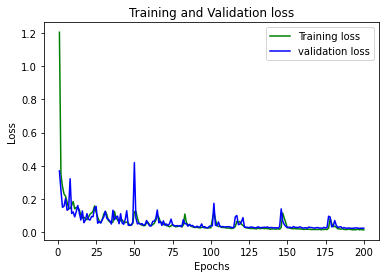

In [33]:
def plot_losses(num_epochs, train_loss_history, val_loss_history): 
    plt.plot(epochs, train_loss_history, 'g', label='Training loss')
    plt.plot(epochs, val_loss_history, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses(epochs=range(1, 201), train_loss_history, val_loss_history)    

In the picture above, train and validation losses are shown in the first phase of training which took 200 epochs. 

After additional 100 epochs with mean squared error, the loss got to a point where it was improving so slowly, it was not worth continuing. 

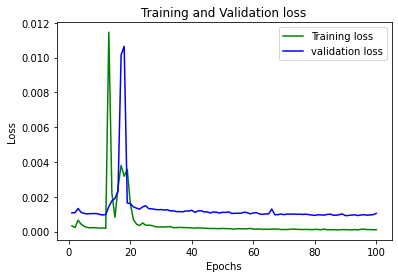

In [19]:
plot_losses(epochs=range(1, 101), train_loss_history, val_loss_history)

Time to see how the models' predictions stack up to ground truth labels.

In [16]:
model.load_state_dict(torch.load('./models/regression_portfolio_phase_2_lr_0.01_lr_01_mse.pt', map_location="cuda:0"))

BATCH_SIZE = 1
NUM_WORKERS = 4

dataset = FetalDatasetResampled(data_path='./data_resampled/', transform=transform_basic, csv_path='./csv/dataset_csv_v2.csv')

_, val_set = torch.utils.data.random_split(dataset, [1800, 213], generator=torch.Generator().manual_seed(42))


val_loader = DataLoader(dataset=val_set,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=True)

mean_error = 0

with torch.no_grad():
    model.eval()
    for i, batch in enumerate(val_loader):
        image, label, meas = batch
        l1 = nn.L1Loss()
        #     image, label, meas = batch
        image = image.to("cuda:0")
        label = label.to("cuda:0")
        meas = meas.to("cuda:0")
        
        normalize = transforms.Normalize([0.5], [0.5])
        img_normalized = normalize(image)
        
        pred_label, pred_meas = model(image)
        pred_meas = pred_meas * 40
        meas = meas.unsqueeze(-1) * 40
        mean_error += l1(pred_meas, meas)
    print(f"Mean error {(mean_error / len(val_loader)):.3f} cm")

Mean error 0.855 cm


My intuition was correct. Error for the model trained for an additional 100 epochs still with L1 loss, resulted in mean error 0.91 cm. It's time to visualize the results.

In [19]:
BATCH_SIZE = 8

transform_no_normalization = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            ])

dataset = FetalDatasetResampled(data_path='./data_resampled/', transform=transform_no_normalization, csv_path='./csv/dataset_csv_v2.csv')

_, val_set = torch.utils.data.random_split(dataset, [1800, 213], generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(dataset=val_set,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=True)


batch = next(iter(val_loader))

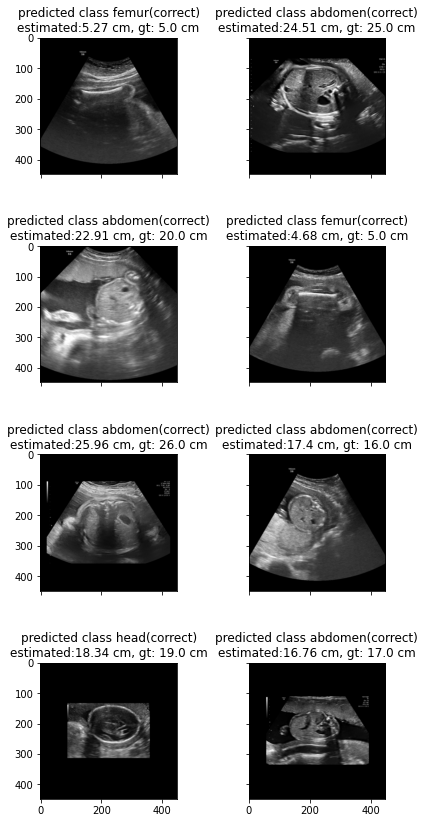

In [21]:
imgs = []
titles = []

model.eval()
with torch.no_grad():
    for i in range(len(batch[0])):
        img = (batch[0][i]).to("cuda:0")
        label = (batch[1][i]).to("cuda:0")
        meas = (batch[2][i]).to("cuda:0")
        normalize = transforms.Normalize([0.5], [0.5])
        img_normalized = normalize(img)
        img_numpy = img.squeeze(0).cpu().detach().numpy()
        pred_label, pred_meas = model(img_normalized.unsqueeze(0))
        _, pred_label = torch.max(pred_label, 1)
        
        if pred_label.item() == label.item():
            classification = "correct"
        else: 
            classification = "incorrect"
            
        if pred_label.item() == 0:
            pred_label = "head"
        elif pred_label.item() == 1:
            pred_label = "abdomen"
        else: 
            pred_label = "femur"
            
        imgs.append(img_numpy)
        titles.append((f"predicted class {pred_label}({classification})"
                     f"\nestimated:{np.round((pred_meas.item() * 40), 2)} cm, gt: {np.round((meas.item() * 40))} cm"))
        
fig = plt.figure(figsize=(12., 14.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 2), 
                 axes_pad=1,  
                 )

for ax, im , title in zip(grid, imgs, titles):
    ax.set_title(title, fontdict=None, loc='center', color = "k")
    ax.imshow(im, cmap='gray')

plt.show()

The figure above shows predictions made on a random batch of 8 images from the validation set. The estimated measurements made by the model are very close to the actual measurements, and well within the range of inter -intra observer error. Moreover, classification is almost 100% accurate.